# Computer Vision CSCI-GA.2272-001 Assignment 1, part 2.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction
This assignment requires you to participate in a Kaggle competition with the rest of the class on the The German Traffic Sign Recognition Benchmark [http://benchmark.ini.rub.de/?section=gtsrb&subsection=news]. The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2021/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file gtsrb_kaggle.csv that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
You should make a copy of this Colab (File->Save a copy in Drive). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is not allowed! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.
Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

### Important Details
• You are only allowed eight (8) submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 0.95. 

• *Extra important:* Please use your NYU NetID as your Kaggle username, so the TAs can figure out which user you are on the leaderboard. 


# Dataset Preparation


1.  Download `dataset.zip` from to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders (`training,validation,testing`). 
3.  Go to Google Drive (on your NYU account) and make a directory `assign2_dataset` (New button --> New Folder).
4.  Upload each of the three subfolders to it (New button --> Folder upload). 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/assign2_dataset/

Mounted at /content/drive
/content/drive/My Drive/assign2_dataset


# Dataloader

In [4]:
!pip install torchsummary
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from torchsummary import summary

batch_size = 32
momentum = 0.9
lr = 0.001
epochs = 20
log_interval = 10
min_valid_loss = np.inf
seed = 1

kwargs = {'num_workers': 2, 'pin_memory': True}
torch.manual_seed(seed)
class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, **kwargs)

In [18]:
train_dataset.y.unique(return_counts=True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42]),
 tensor([ 120, 2130, 2160, 1320, 1890, 1770,  330, 1350, 1320, 1380, 1920, 1230,
         2010, 2070,  690,  540,  330, 1020, 1110,  120,  270,  240,  300,  420,
          180, 1410,  510,  150,  450,  180,  360,  690,  150,  599,  330, 1110,
          300,  120, 1980,  210,  270,  150,  150]))

# Model

**Model story**

Model architecture inspired by Lecture 3 where we discussed how more Convolution layers are helpful compared to adding linear(dense) layers. I kept only one linear layer and 3 convolution layers.

Dropout after every conv layer didn't help here. Without dropout, the model was overfitting on train set with 0.0 loss but on the validation set the loss wasn't decreasing. This created a requirement of adding batchnormalisation to the convolution layers which acts as a regularizer and eliminates the need of Dropout. [ref. arXiv:1502.03167 [Batch Normalization](https://arxiv.org/abs/1502.03167) ]

Optimizer:
[AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) (Modified Adam optimizer) with weight decay worked out better compared to SGD and Adam optimizer. I am using Leaky ReLU as activation function for each convolution layer which works better compared to Vanilla ReLU.

In [6]:
nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.LazyLinear(512)
        self.fc2 = nn.LazyLinear(nclasses)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)),2))
        x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)),2))
        x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)),2))
        x = self.conv_drop(x)
        x = x.view(-1, int(1024))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Training

In [7]:
model = Net()
summary(model, (3, 32, 32))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           9,728
       BatchNorm2d-2          [-1, 128, 14, 14]             256
         Dropout2d-3          [-1, 128, 14, 14]               0
            Conv2d-4          [-1, 256, 12, 12]         295,168
       BatchNorm2d-5            [-1, 256, 6, 6]             512
         Dropout2d-6            [-1, 256, 6, 6]               0
            Conv2d-7            [-1, 256, 4, 4]         590,080
       BatchNorm2d-8            [-1, 256, 2, 2]             512
         Dropout2d-9            [-1, 256, 2, 2]               0
           Linear-10                  [-1, 512]         524,800
           Linear-11                   [-1, 43]          22,059
Total params: 1,443,115
Trainable params: 1,443,115
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [8]:
"""next steps"""
# print average f1 score after every epoch
# Normalize the input variables (zero mean, unit variance)

# Later on
# ensemble

"""::changes"""
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-2)
# optimizer = optim.Adam(model.parameters(), weight_decay=1e-2)
def train(epoch):
    model.train() # train mode, 
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # reset old gradients of previous epoch
        output = model(data) # this calls __call__ of the nn.Module class which has forward function called
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(train_loader.dataset)

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step() # notifies the optimizer of one step
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss, accuracy


# lost collab connection, resuming from epoch 14

model = Net()
model_file = 'model_13.pth'
model.load_state_dict(torch.load(model_file))

for epoch in range(14, epochs + 1):
    train(epoch)
    valid_loss, valid_accuracy = validation()
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    # start
    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss
         
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
    # end 
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train Epoch: 14 [0/35339 (0%)]	Loss: 0.000470
Train Epoch: 14 [320/35339 (1%)]	Loss: 0.000407
Train Epoch: 14 [640/35339 (2%)]	Loss: 0.012113
Train Epoch: 14 [960/35339 (3%)]	Loss: 0.165384
Train Epoch: 14 [1280/35339 (4%)]	Loss: 0.023716
Train Epoch: 14 [1600/35339 (5%)]	Loss: 0.004177
Train Epoch: 14 [1920/35339 (5%)]	Loss: 0.000000
Train Epoch: 14 [2240/35339 (6%)]	Loss: 0.051301
Train Epoch: 14 [2560/35339 (7%)]	Loss: 0.017371
Train Epoch: 14 [2880/35339 (8%)]	Loss: 0.001698
Train Epoch: 14 [3200/35339 (9%)]	Loss: 0.018743
Train Epoch: 14 [3520/35339 (10%)]	Loss: 0.030999
Train Epoch: 14 [3840/35339 (11%)]	Loss: 0.037293
Train Epoch: 14 [4160/35339 (12%)]	Loss: 0.006779
Train Epoch: 14 [4480/35339 (13%)]	Loss: 0.000381
Train Epoch: 14 [4800/35339 (14%)]	Loss: 0.030941
Train Epoch: 14 [5120/35339 (14%)]	Loss: 0.001143
Train Epoch: 14 [5440/35339 (15%)]	Loss: 0.002555
Train Epoch: 14 [5760/35339 (16%)]	Loss: 0.072225
Train Epoch: 14 [6080/35339 (17%)]	Loss: 0.013327
Train Epoch: 14 [

Lost connection to collab after 13th epoch, resumed training from 14th epoch, hence less datapoints on the plot

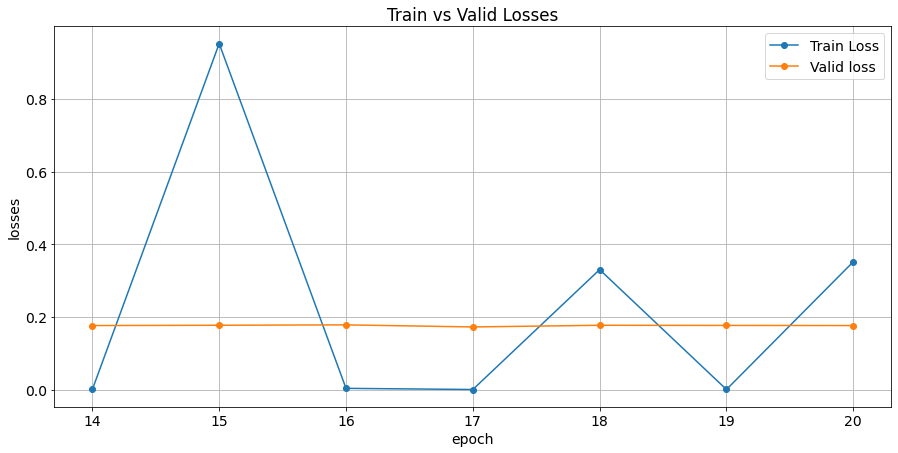

In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
epoch_list = list(range(14,21))
plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(epoch_list, train_losses,'-o')
plt.plot(epoch_list, valid_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train Loss','Valid loss'])
plt.title('Train vs Valid Losses')
 
plt.show()

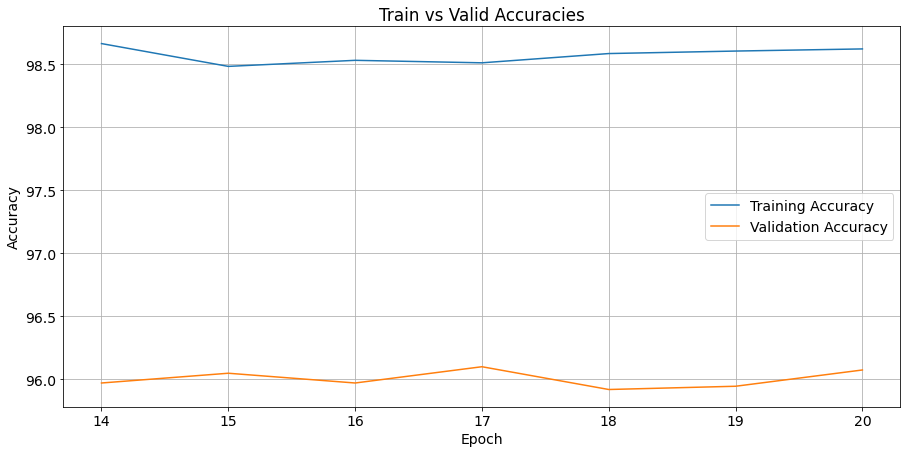

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(epoch_list, train_accuracies)
plt.plot(epoch_list, valid_accuracies)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='right')
plt.ylabel(u'Accuracy')
plt.xlabel(u'Epoch')
plt.title('Train vs Valid Accuracies')
plt.grid(True)
plt.show()

# Evaluate and Submit to Kaggle



In [11]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle_4_conv_2linear.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

model_file = "model_20.pth"
model = Net()
model.load_state_dict(torch.load(model_file))
model.eval()
for i, data in enumerate(test_data):
    data = data.unsqueeze(0)

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Written to csv file gtsrb_kaggle_4_conv_2linear.csv


In [12]:
print("was able to submit it")

was able to submit it


# Submitting to Kaggle

Now take this csv file, download it from your Google drive and then submit it to Kaggle to check performance of your model.